In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import keras.utils as image
import glob
from tqdm import tqdm
sns.set()

In [2]:
parent_dir = "D:\Jupyter Notebook\BreastCancerDetection\IDC_regular_ps50_idx5"
dir_list = os.listdir(parent_dir)
print(dir_list[:5])

['10253', '10254', '10255', '10256', '10257']


#### example path of a .png file : D:\Jupyter Notebook\BreastCancerDetection\IDC_regular_ps50_idx5\8863\0\8863_idx5_x51_y1251_class0.png

In [3]:
N_IDC, P_IDC = [], [] #This list will contain all the paths to the images. 
#NOTE: Keep in mind whereever I have written negative or positive in this entire notebook, it refers to '0' and '1' respectively.


for dir_name in tqdm(dir_list):
    #For adding negaive paths.
    negative_file_path = os.path.join(parent_dir,dir_name,'0')#will contain path of the negative folders.
    negative_image_names = os.listdir(negative_file_path)
    for negative_image_name in negative_image_names:
        N_IDC.append(os.path.join(parent_dir,dir_name,'0',negative_image_name))
        #or we could have also written it as ...

    
    #For adding positive paths.        
    positive_file_path = os.path.join(parent_dir,dir_name,'1')#will contain path of the positive folders.
    positive_image_names = os.listdir(positive_file_path)#positive_image_names is a list that will hold the names of images...
    #that are inside the folder of '1'
    for positive_image_name in positive_image_names:
        P_IDC.append(os.path.join(parent_dir,dir_name,'1',positive_image_name))


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [00:04<00:00, 66.53it/s]


In [4]:
N_IDC[:5]

['D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png']

In [5]:
P_IDC[:5]

['D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png',
 'D:\\Jupyter Notebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']

In [6]:
print("Number of negative test IDC : "+str(len(N_IDC)))
print("Number of positive test IDC : "+str(len(P_IDC)))

Number of negative test IDC : 198738
Number of positive test IDC : 78786


### Since we know there is a clear imbalance we will crop down the size of the images. The problem is that ideally we should have taken both the sizes as 78,786 for each but we will drop it down even more further because it is throwing memory error for that much amount of data. So, 50,000 sounds good.

### update 1: It is throwing memory error even at 50,000 so dropping it down to 40,000 samples.

### update 2: Same, dropping it to 35,000

In [7]:
NEW_SIZE = 35000

N_IDC = N_IDC[:NEW_SIZE]
P_IDC = P_IDC[:NEW_SIZE]
len(N_IDC)

35000

### Printing random images.

In [8]:
random_indicies = np.random.randint(50, NEW_SIZE, 4) #low,high,number of elements
random_indicies

array([ 3615, 30694, 16870, 15973])

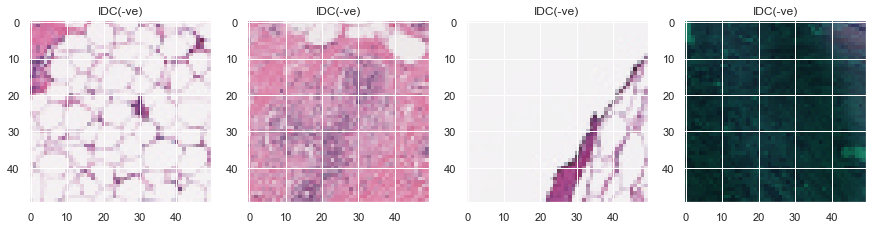

In [9]:
plt.figure(figsize=(15,15))
for i in range(4):
    img = image.load_img(N_IDC[random_indicies[i]])
    plt.subplot(1,4,1+i)
    plt.imshow(img)
    plt.title('IDC(-ve)')

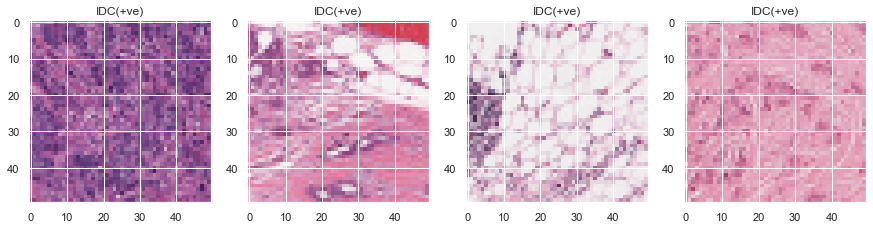

In [10]:
plt.figure(figsize=(15,15))
for i in range(4):
    img = image.load_img(P_IDC[random_indicies[i]])
    plt.subplot(1,4,1+i)
    plt.imshow(img)
    plt.title('IDC(+ve)')

### Now reading the paths of image with cv2 and storing in a np.array format.

In [11]:
#Since, the lists N_IDC and P_IDC contains paths,
#So, we will create 2 more empty arrays of fixed dimension that will contain the pixel info in np.array form.
image_N_IDC = np.zeros(shape=(len(N_IDC),50,50,3),dtype=np.float)
image_P_IDC = np.zeros(shape=(len(N_IDC),50,50,3),dtype=np.float)

#Side by side will create 2 more lists that will contain the list of targets for both.
target_N_IDC, target_P_IDC = [], [] #Firstwill contain only '0's and second with only '1's.

#keep in mind that there a few images inside these folders that are cropped i.e. not of the dimension 50x50.
#So for that we will have to resize ever image. Those who are already of the same size will remain the same but those which..
#are not will change to 50x50x3.

for i,image_path in tqdm(enumerate(N_IDC)):
    image_array = cv2.imread(image_path,cv2.IMREAD_COLOR)#First will have to read the path and store as an image.
    #Only then we can change the shape. We can NOT directly use the .resize() function.
    resized_image_array = cv2.resize(image_array,(50,50),interpolation = cv2.INTER_LINEAR)
    #We will give it the image_array, the desired dimension we want and the method of interpolation.
    #The interpolation part looks complex but actually isn't, we are just specifying a method to change dimensions.
    image_N_IDC[i]=resized_image_array#Notice we are not adding/appending anything here.
    #We updateding the image_N_IDC array and hence toggling through the array with [i]
    target_N_IDC.append(0)
    
#same with posiktive data.
for i,image_path in tqdm(enumerate(P_IDC)):
    image_array = cv2.imread(image_path,cv2.IMREAD_COLOR)#First will have to read the path and store as an image.
    #Only then we can change the shape. We can NOT directly use the .resize() function.
    resized_image_array = cv2.resize(image_array,(50,50),interpolation = cv2.INTER_LINEAR)
    image_P_IDC[i]=resized_image_array#Notice we are not adding/appending anything here.
    #We updateding the image_N_IDC array and hence toggling through the array with [i]
    target_P_IDC.append(1)
    
#This code will take a descent amount of time, be patient.

C:\Users\kunal\AppData\Local\Temp\ipykernel_13608\1744614145.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_N_IDC = np.zeros(shape=(len(N_IDC),50,50,3),dtype=np.float)
C:\Users\kunal\AppData\Local\Temp\ipykernel_13608\1744614145.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_P_IDC = np.zeros(shape=(len(N_IDC),50,50,3

In [12]:
print("image array size for negative: "+str(image_N_IDC.shape))
print("image array size for positve:  "+str(image_P_IDC.shape))

image array size for negative: (35000, 50, 50, 3)
image array size for positve:  (35000, 50, 50, 3)


### Now joining the negative and positive image arrays.

In [13]:
#We do that with a function called 'concatenate' 
inputs = np.concatenate((image_N_IDC, image_P_IDC), axis = 0)#axis=0 says that added in terms of rows, one below the other.
targets = np.concatenate((target_N_IDC, target_P_IDC), axis = 0)

#This code will take a descent amount of time, be patient.

In [14]:
print("new input image array size: "+str(inputs.shape))
print("new target size:  "+str(targets.shape))

new input image array size: (70000, 50, 50, 3)
new target size:  (70000,)


### Shuffling the data to completely randomize the data. 

In [15]:
inputs ,targets = shuffle(inputs , targets, random_state = 0)#Notice that we call the shuffle function at once...
#simultaniously to maintain the shuffle order with the targets data.

#This code will take a descent amount of time, be patient.

### Splitting data into test and train data.

In [16]:
x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.1)
x_train.shape
#This code will take a descent amount of time, be patient.

(63000, 50, 50, 3)

In [17]:
y_train.shape

(63000,)

### Splitting the training data further into train and validation data.

In [18]:
x_train,x_validation,y_train,y_validation = train_test_split(x_train ,y_train ,test_size=0.2)
x_train.shape

#This code will take a descent amount of time, be patient.

(50400, 50, 50, 3)

In [19]:
x_validation.shape

(12600, 50, 50, 3)

### Now creating the model itself.

In [20]:
input_size = 50*50*3
output_size = 2 #Since we want the to deteermine +ve or -ve test for IDC

model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(filters=32,kernel_size=(6,6),activation='relu',input_shape=(50,50,3)),
                            tf.keras.layers.MaxPooling2D((2,2)), #This is the first hidden layer.
                            #using 32 filters for the first hidden layer.
                            
                            tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
                            tf.keras.layers.MaxPooling2D((2,2)), #This is the second hidden layer.
                            #using 64 filters for the second hidden layer.
    
                            tf.keras.layers.Conv2D(filters=128,kernel_size=(4,4),activation='relu'),
                            tf.keras.layers.MaxPooling2D((2,2)), #This is the third hidden layer.
                            #using 96 filters for the second hidden layer.
                            
                            tf.keras.layers.Flatten(), #The values and all will be intact of the 4th hidden layer
    
                            tf.keras.layers.Dense(1000,activation='relu'),   #5th layer  
    
                            tf.keras.layers.Dense(500,activation='relu'),   #6th layer  
                            
                            tf.keras.layers.Dense(100,activation='relu'),    #7th layer
                            
                            tf.keras.layers.Dense(output_size,activation='softmax') #Final 8th layer
                            #our model will predict.
                            
                            ]) #Notice for the activation we ues softmax, Since we want to give probality.

In [21]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 45, 45, 32)        3488      
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

In [23]:
NUM_EPOCHS = 50
BATCH_SIZE = 100
#The above are our hyperparamters and we will tune it according to our analysis.

early_stopping = tf.keras.callbacks.EarlyStopping() #Will instantly stop the process if it detects a increase in validation_acc
history = model.fit(x_train,
                    y_train, 
                    epochs=NUM_EPOCHS,
                    validation_data=(x_validation,y_validation),
                    callbacks = [early_stopping],
                    batch_size = BATCH_SIZE,
                    verbose=1)

Epoch 1/50
504/504 [==============================] - 135s 264ms/step - loss: 0.8873 - accuracy: 0.5773 - val_loss: 0.6141 - val_accuracy: 0.6712
Epoch 2/50
504/504 [==============================] - 138s 274ms/step - loss: 0.6016 - accuracy: 0.6784 - val_loss: 0.5271 - val_accuracy: 0.7371
Epoch 3/50
504/504 [==============================] - 127s 251ms/step - loss: 0.5263 - accuracy: 0.7411 - val_loss: 0.5004 - val_accuracy: 0.7562
Epoch 4/50
504/504 [==============================] - 128s 255ms/step - loss: 0.5076 - accuracy: 0.7522 - val_loss: 0.5161 - val_accuracy: 0.7471


In [24]:
history.history??

Text(0.5, 1.0, 'Loss vs Epochs')

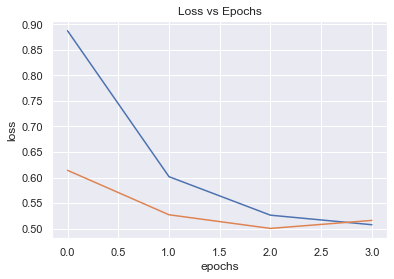

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')

In [26]:
print("Training accuracy : " + str(history.history['accuracy'][3]*100.00)+'%')
print("Validation accuracy : " + str(history.history['val_accuracy'][3]*100.00)+'%')

Training accuracy : 75.21825432777405%
Validation accuracy : 74.70635175704956%


Text(0.5, 1.0, 'Accuracy vs Epochs')

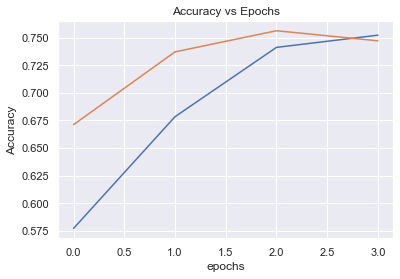

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

### Now we are ready to test the model. This is no point of return, we can NOT make any changes after this.

In [28]:
test_loss, test_acc = model.evaluate(x_test,y_test)

219/219 [==============================] - 3s 13ms/step - loss: 0.5156 - accuracy: 0.7460


In [29]:
test_loss

0.5156068205833435

In [30]:
print("Test accuracy : " +str(test_acc*100.00))
print("Validation accuracy : " +str(history.history['val_accuracy'][3]*100.00))

Test accuracy : 74.59999918937683
Validation accuracy : 74.70635175704956


In [31]:
y_prediction = model.predict(x_test)

219/219 [==============================] - 4s 15ms/step


In [32]:
y_prediction = [np.argmax(arr) for arr in y_prediction] #argmax() will return the index of the element inside the list with...
#maximum value. Basicly it's prediction but hardmax.
#So, this matrix will hold the prediction number out of 10.
y_prediction

[0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,


Text(102.5, 0.5, 'True')

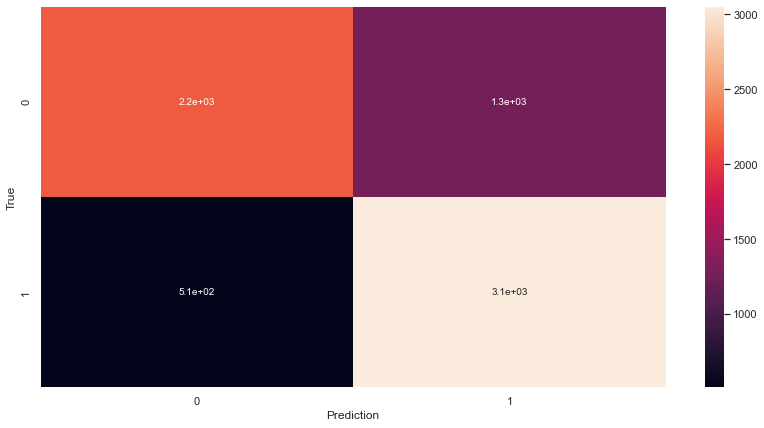

In [33]:
plt.figure(figsize=(14,7))
sns.heatmap(confusion_matrix(y_test,y_prediction),annot=True)
plt.xlabel('Prediction')
plt.ylabel('True')